# VGG-16_functional

### VGGNet
* 2014년 ILSVRC 준우승 모델 / error_rate:10%
* Oxford 대학교 Visual Geometry Group의 Karen Simonyan과 Andrew Zisserman이 제안한 모델
* Large scale image recognition
* 3x3 Convolution filter
* Increasing depth

1. Architecture
    - Factorizing convolution → Implicit regularization
    - Pre-initialization (Like auxiliary classifier in GoogLeNet)
    - FC layer → Conv. layer
2. Dataset(augmentation)
    - Scale jittering
    - Multi-crop (GoogLeNet) and dense evalutation (OverFeat)

* 약 1537만개의 parameter

## Mount Google Drive

In [ ]:
# Colab 사용시
# from google.colab import drive
# drive.mount('/content/drive')

## Import Library

In [ ]:
# Data
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from keras.datasets import cifar10

# Preprcessing

# Model
import tensorflow as tf
from tensorflow.keras import Sequential, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Visualizatoin
from tensorflow.keras.utils import plot_model
from PIL import Image
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Env
import os

## GPU Setting

In [ ]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

## Hyper parameters

In [ ]:
#Path
DATA_DIR='../data/'
SAVE_DIR='../model/VGGNet/'
LOAD_DIR='../model/VGGNet/'

#Hyper parameter
BATCH_SIZE=32
VERBOSE=1
PATIENCE=20
VALIDATION_SPLIT=0.2
EPOCHS=300

## Load data

In [ ]:
(X_train_raw, y_train), (X_test_raw, y_test) = cifar10.load_data()

In [ ]:
np.info(X_train_raw)

### Matplotlib Image

In [ ]:
plt.imshow(X_train_raw[0], cmap='gray_r', interpolation='nearest')
plt.show()

### PIL Image

In [ ]:
# pil_image = Image.fromarray(X_train_raw[0])
# pil_image.show()

## Preprocessing

### Numpy to Tensor

In [ ]:
X_train_tensor = tf.convert_to_tensor(X_train_raw)
X_test_tensor = tf.convert_to_tensor(X_test_raw)

In [ ]:
X_train_tensor.shape

### Min-Max Scaling

In [ ]:
X_train_scaled, X_test_scaled = X_train_tensor/255, X_test_tensor/255

In [ ]:
X_train_scaled.shape

In [ ]:
X_train, X_test = X_train_scaled, X_test_scaled

In [ ]:
X_train[0].shape

## Model definition
### VGG-16

Functional API

In [ ]:
def VGG_16():
    # inputs
    inputs = tf.keras.Input(X_train[0].shape)
    
    # Resizing layer
    # resize = tf.keras.layers.Resizing(height=227, width=227, interpolation='bilinear')(inputs)
    
    # Initialize convolution layer
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=activations.relu)(inputs)
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation=activations.relu)(conv_1)

    pool_1 = tf.keras.layers.MaxPool2D()(conv_2)

    conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation=activations.relu)(pool_1)
    conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation=activations.relu)(conv_3)

    pool_2 = tf.keras.layers.MaxPool2D()(conv_4)

    conv_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',activation=activations.relu)(pool_2)
    conv_6 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',activation=activations.relu)(conv_5)
    conv_7 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',activation=activations.relu)(conv_6)

    pool_3 = tf.keras.layers.MaxPool2D()(conv_7)

    conv_8 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',activation=activations.relu)(pool_3)
    conv_9 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',activation=activations.relu)(conv_8)
    conv_10 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',activation=activations.relu)(conv_9)

    pool_4 = tf.keras.layers.MaxPool2D()(conv_10)

    conv_11 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',activation=activations.relu)(pool_4)
    conv_12 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',activation=activations.relu)(conv_11)
    conv_13 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',activation=activations.relu)(conv_12)

    pool_5 = tf.keras.layers.MaxPool2D()(conv_13)

    flatten = tf.keras.layers.Flatten()(pool_5)
    dense_1 = tf.keras.layers.Dense(units=512, activation=activations.relu)(flatten)
    dense_2 = tf.keras.layers.Dense(units=512, activation=activations.relu)(dense_1)
    outputs = tf.keras.layers.Dense(units=10, activation=activations.softmax)(dense_2)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)
    

### Model Summary

In [ ]:
model = VGG_16()
# model.summary()

In [ ]:
# plot_model(model)

## Model Compile

In [ ]:
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR+'best-model.hdf5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

#compile
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

## Train Model

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es, mcp], validation_split=VALIDATION_SPLIT)

## Test Model

In [ ]:
loaded_model = load_model(SAVE_DIR+'best-model.hdf5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

## Save Model

In [ ]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

## Evaluation

### Loss / Accuracy

In [ ]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
plt.show()

In [ ]:
fig, acc_ax = plt.subplots()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')

acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

# loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

# acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()


### Confusion matrix

In [ ]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

In [ ]:
# constant for classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(10, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + 'output.png')

### precision, recall, f1 score

In [ ]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score_s = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score_s)

## Load Model

In [ ]:
model_name='trained-model.h5'
model_path=os.path.join(LOAD_DIR, model_name)
model=load_model(model_path)

## Predict

In [ ]:
print(X_train.shape, X_train[0].shape, sep='\n')

In [ ]:
def predict_mnist(tensor, model):
    sample=tf.reshape(tensor, [-1, 32, 32, 3])
    result_prob=model.predict(sample, verbose=0)
    result=np.argmax(result_prob)
    print(result)

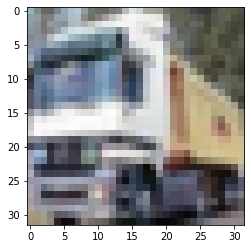

In [49]:
plt.imshow(X_train[1], cmap='gray_r', interpolation='nearest')
plt.show()

In [50]:
predict_mnist(X_train[1], model)

9
